In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import plotly.express as px
import numpy as np
import plotly.io as pio
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.preprocessing as skp
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway


ModuleNotFoundError: No module named 'matplotlib'

# Introduction  
Airbnb is a popular online marketplace connecting hosts with guests for short-term lodging and has transformed the way people book accommodations. In cities like New York, thousands of listings vary in price depending on factors such as location, room type, seasonality, and reviews. Accurately predicting Airbnb prices can help both hosts set competitive prices and guests find the best value. This project aims to explore and model the determinants of Airbnb pricing using real-world datasets, with the goal of building a predictive tool.  
## Objectives  
- Analyze key factors that influence Airbnb listing prices (e.g. neighborhood, room type, keywords in the description, minimum nights, availability)
- Visualize the distribution of prices across different neighborhoods and room types
- Evalute performances of existing models on predicting nightly prices of a listing
- Generate insights that help hosts set optimal pricing and guide guests on fair value

#### Analysis 1: Popularity of Neighbourhood Segmented by Room Type
In this section, we conducted a subgroup analysis to examine the total number of reviews by neighbourhood group and room type. Review count is a metric of choice to indicate popularity of a listing. 

Data cleaning: last-review is converted to datetime, and missing dates are filed with earliest date. Last review month is extracted for grouping and analysis. Missing values in 'reviews_per_month' is filled with 0.

In [ ]:
# Load the dataset
file_path = 'data/AB_NYC_2019.csv'
data = pd.read_csv(file_path)
data.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
# Convert 'last_review' to datetime
data['last_review'] = pd.to_datetime(data['last_review'], errors='coerce')
# Fill missing values in 'last_review' with the earliest date
min_date = data['last_review'].min()
data['last_review'] = data['last_review'].fillna(min_date)
# Extract month from 'last_review' to create 'review_month'
data['review_month'] = data['last_review'].dt.month

# Fill missing values in 'reviews_per_month' with 0
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

We began by grouping the dataset by both neighbourhood_group and room_type, and then aggregating the sum of number_of_reviews for each subgroup. This enabled us to generate a stacked bar chart, which visually represents how review volumes are distributed across different boroughs and types of accommodations. By unstacking the grouped data, we were able to isolate the contributions of each room type within a given neighbourhood group and plot them in a stacked format for comparative analysis.    

<Figure size 1200x600 with 0 Axes>

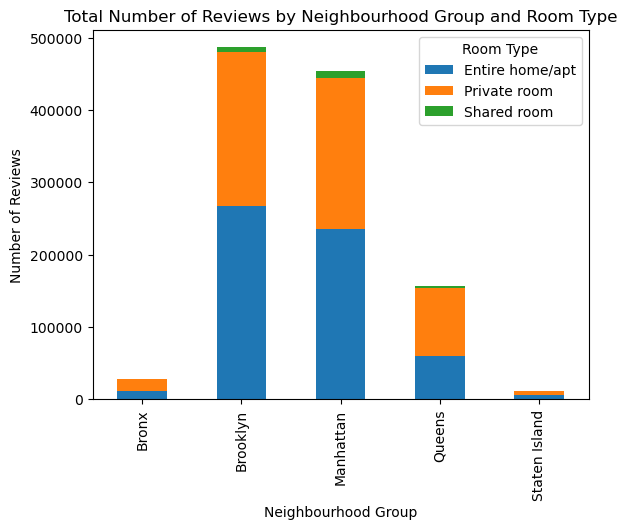

In [ ]:
# Stacked Bar Chart: Total Number of Reviews by Neighbourhood Group and Room Type
room_type_reviews = data.groupby(['neighbourhood_group', 'room_type'])['number_of_reviews'].sum().unstack()
plt.figure(figsize=(12, 6))
room_type_reviews.plot(kind='bar', stacked=True)
plt.title('Total Number of Reviews by Neighbourhood Group and Room Type')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.legend(title='Room Type')
plt.show()

From the visualization, we observe that Manhattan and Brooklyn stand out as the most active boroughs in terms of Airbnb engagement, as evidenced by their significantly higher total review counts. Notably, the majority of reviews within these boroughs pertain to entire homes or apartments, suggesting a strong preference or supply of such listings. Conversely, private rooms account for a larger proportion of reviews in boroughs such as Queens and the Bronx, indicating possible differences in guest demographics or pricing structures. Shared rooms and hotel rooms consistently appear as marginal categories across all neighbourhoods. 

#### Analysis 2: Popularity of Neighbourhood Segmented by Price Range
In this analysis, we investigate the distribution of total Airbnb reviews across neighbourhood groups, segmented by defined price ranges. To achieve this, we first categorized listings into price brackets using the pd.cut function, creating seven intervals: 0–50, 51–100, 101–150, 151–200, 201–300, 301–500, and 501–1000. We then aggregated the total number of reviews within each neighbourhood_group and price_range combination, and visualized the results as a stacked bar chart.

/var/folders/sz/8qmyth415gq44nzg8jv3kkk00000gn/T/ipykernel_36486/1717920389.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Figure size 1200x600 with 0 Axes>

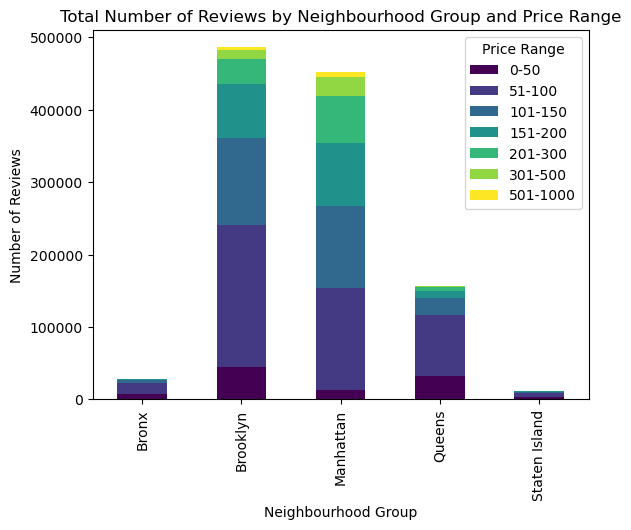

In [ ]:
# Define price ranges
bins = [0, 50, 100, 150, 200, 300, 500, 1000]
labels = ['0-50', '51-100', '101-150', '151-200', '201-300', '301-500', '501-1000']
data['price_range'] = pd.cut(data['price'], bins=bins, labels=labels, right=False)

# Stacked Bar Chart: Total Number of Reviews by Neighbourhood Group and Price Range
price_range_reviews = data.groupby(['neighbourhood_group', 'price_range'])['number_of_reviews'].sum().unstack()
plt.figure(figsize=(12, 6))
price_range_reviews.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Total Number of Reviews by Neighbourhood Group and Price Range')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.legend(title='Price Range')
plt.show()

We observe that Brooklyn and Manhattan once again lead in total review counts. In both boroughs, the majority of reviews are concentrated in the mid-range price categories, particularly 51–100 and 101–150 USD. Manhattan, however, shows relatively stronger representation in higher-end segments (201–300 and above), consistent with its status as a premium destination. Queens and the Bronx have more modest overall review counts, but they show a notable skew toward lower price categories, indicating a potentially more budget-conscious visitor base. Staten Island exhibits minimal review activity across all price ranges. 

#### Analysis 3: Popularity of Individual Neighbourhoods by Borough  

In this analysis, we focus on identifying the most reviewed individual neighbourhoods within each of New York City’s five main boroughs. To do this, we first grouped the data by neighbourhood_group and neighbourhood, summing the total number of reviews for each pair. Then, for each neighbourhood group, we selected only the top three neighbourhoods with the highest total reviews. The resulting subset was reshaped for visualization and plotted as a stacked bar chart, where each bar represents a borough and is segmented by its top-performing neighbourhoods.

<Figure size 1200x600 with 0 Axes>

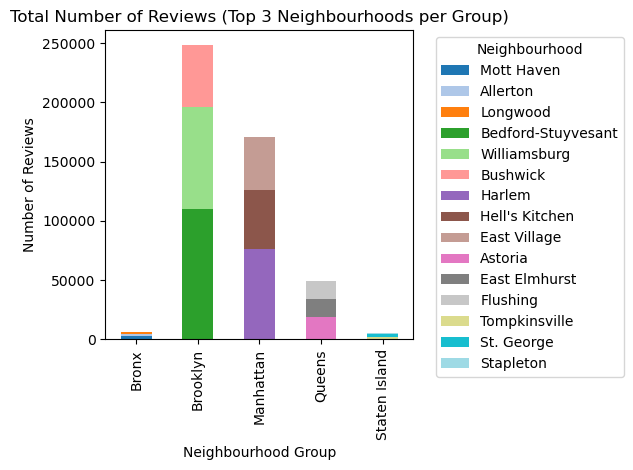

In [ ]:
grouped = data.groupby(['neighbourhood_group', 'neighbourhood'])['number_of_reviews'].sum()

# For each neighbourhood group, keep only the top 3 neighbourhoods
top3 = grouped.groupby(level=0, group_keys=False).nlargest(3)
top3_unstacked = top3.unstack(fill_value=0)

plt.figure(figsize=(12, 6))
top3_unstacked.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Total Number of Reviews (Top 3 Neighbourhoods per Group)')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.legend(title='Neighbourhood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The chart reveals significant variation in review concentration within each borough. In Brooklyn and Manhattan, a small number of neighbourhoods dominate the review volume, with Bedford-Stuyvesant and Williamsburg in Brooklyn, and Harlem and the East Village in Manhattan, contributing substantially to their respective borough totals. These patterns suggest that guest activity is highly concentrated in specific, popular locales within otherwise large and diverse boroughs. In contrast, the Bronx, Queens, and Staten Island show a more modest scale of engagement, though even within these, particular neighbourhoods such as Mott Haven (Bronx), Astoria (Queens), and St. George (Staten Island) emerge as local hubs of Airbnb activity. 

#### Analysis 4: Monthly Distribution of Airbnb Reviews Segmented by Neighbourhood  
In this section, we analyze the monthly distribution of Airbnb reviews across New York City’s five neighbourhood groups for the year 2019. To generate this visualization, we first grouped the data by review_month and neighbourhood_group, summing the number_of_reviews within each subgroup. We then created a stacked bar chart to illustrate the volume of reviews received each month, disaggregated by borough. 

<Figure size 1400x800 with 0 Axes>

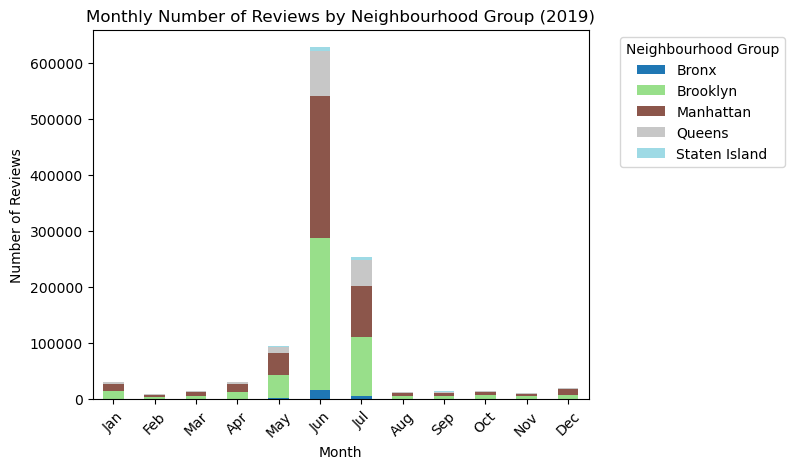

In [ ]:
monthly_reviews = data.groupby(['review_month', 'neighbourhood_group'], observed=False)['number_of_reviews'].sum().unstack()

# Plot stacked bar chart
plt.figure(figsize=(14, 8))
monthly_reviews.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Monthly Number of Reviews by Neighbourhood Group (2019)')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(title='Neighbourhood Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The resulting plot reveals a pronounced seasonal trend, with a dramatic spike in reviews during the summer months—particularly in June and July. Brooklyn and Manhattan dominate this peak period, accounting for the majority of reviews during these months, suggesting that these boroughs are key drivers of the city’s short-term rental market during high tourism season. In contrast, review activity is minimal throughout the rest of the year across all neighbourhood groups, including traditionally quieter areas such as Staten Island and the Bronx. The concentrated volume in the middle of the year likely reflects both increased travel demand and host responsiveness during peak tourism months. 

#### Analysis 5: Identifying Spatial Patterns in Airbnb Listings Using K-Means Clustering

We employed K-means clustering to identify spatial groupings—or "hotspots"—of Airbnb listings across New York City. We began by extracting the latitude and longitude coordinates of all listings with valid geolocation data.     

To determine an appropriate number of clusters, we applied the Elbow Method: K-means models were trained for values of k ranging from 1 to 10, and we plotted the corresponding inertia values (a measure of within-cluster dispersion).

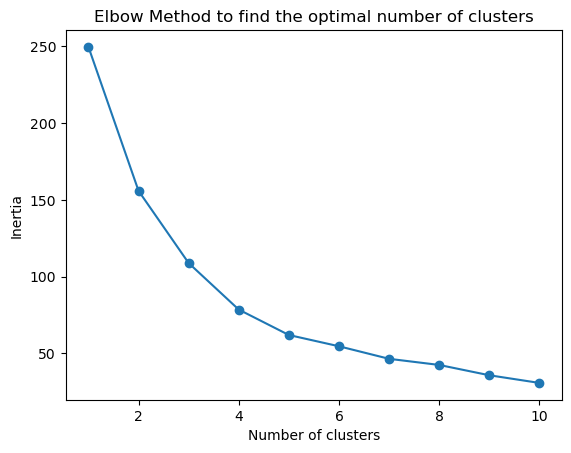

In [ ]:
coords = data[['latitude', 'longitude']].dropna().values
inertias = []
K = range(1, 11)
for k in K:
    model = KMeans(n_clusters=k, random_state=42).fit(coords)
    inertias.append(model.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to find the optimal number of clusters')
plt.show()


The plot revealed a clear inflection point around k = 4, suggesting that four clusters may offer a balanced trade-off between model complexity and explanatory power.

Based on this insight, we trained a K-means model with four clusters and assigned each listing a corresponding cluster label. To visualize the resulting spatial segmentation, we created an interactive map using Plotly's scatter_mapbox. 

In [ ]:

kmeans = KMeans(n_clusters=4, random_state=0).fit(coords)
data['cluster'] = kmeans.labels_

fig = px.scatter_map(data, lat='latitude', lon='longitude', color='cluster',
                        title='Hotspots of Listings',
                        labels={'cluster': 'Cluster'},
                        map_style='carto-positron',
                        zoom=10, height=600)
fig.update_layout(mapbox=dict(center=dict(lat=data['latitude'].mean(), lon=data['longitude'].mean())))
fig.show()

Each listing is colored by its assigned cluster, and the map is centered over the city with a consistent zoom level for clarity. The resulting visualization reveals distinct spatial concentrations of listings—such as dense clusters in Manhattan, Brooklyn, and parts of Queens—highlighting the areas where Airbnb activity is most intense. 

#### Analysis 6: Review and Price

In [ ]:
df = pd.read_csv('../archive/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

##### 6.1 Exploratory Data Analysis
##### 6.1.1 Statistical Overview

In [ ]:
# Descriptive Statistics
df[['price', 'number_of_reviews', 'reviews_per_month']].describe()

,price,number_of_reviews,reviews_per_month
count,48895.000000,48895.000000,38843.000000
mean,152.720687,23.274466,1.373221
std,240.154170,44.550582,1.680442
min,0.000000,0.000000,0.010000
25%,69.000000,1.000000,0.190000
50%,106.000000,5.000000,0.720000
75%,175.000000,24.000000,2.020000
max,10000.000000,629.000000,58.500000


During the initial exploration of the data, several important observations emerged. First, the minimum value of the price column is 0, which is highly unrealistic in the context of Airbnb listings and suggests the presence of outliers or incorrect data entries that will need to be addressed. Additionally, the maximum price value is significantly higher compared to the mean and median, indicating a highly skewed distribution and the likely presence of extreme outliers that could disproportionately influence the analysis. Regarding the reviews_per_month column, it is important to note that the descriptive statistics only account for non-null values. However, many null values may exist in this column, and these likely represent listings with zero reviews rather than missing or erroneous data. Therefore, appropriate preprocessing steps will be necessary to handle both outliers and missing values accurately before proceeding with more in-depth analysis and modeling.

In [ ]:
# Checking for null values
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
#check the number of rows where last_review and reviews_per_month are both null
count = df[(df['last_review'].isnull()) & (df['reviews_per_month'].isnull())].shape[0]
print(count)

10052


As shown above there is a high number of null values for last_review and reviews_per_month column, and from the fact that the number of missing values for last_review and reviews_per_month are the same and that the number of rows with null values on both columns is also the same, we can infer that listings without a recorded last review also have no reviews per month, meaning the null values likely indicate listings with no reviews at all.

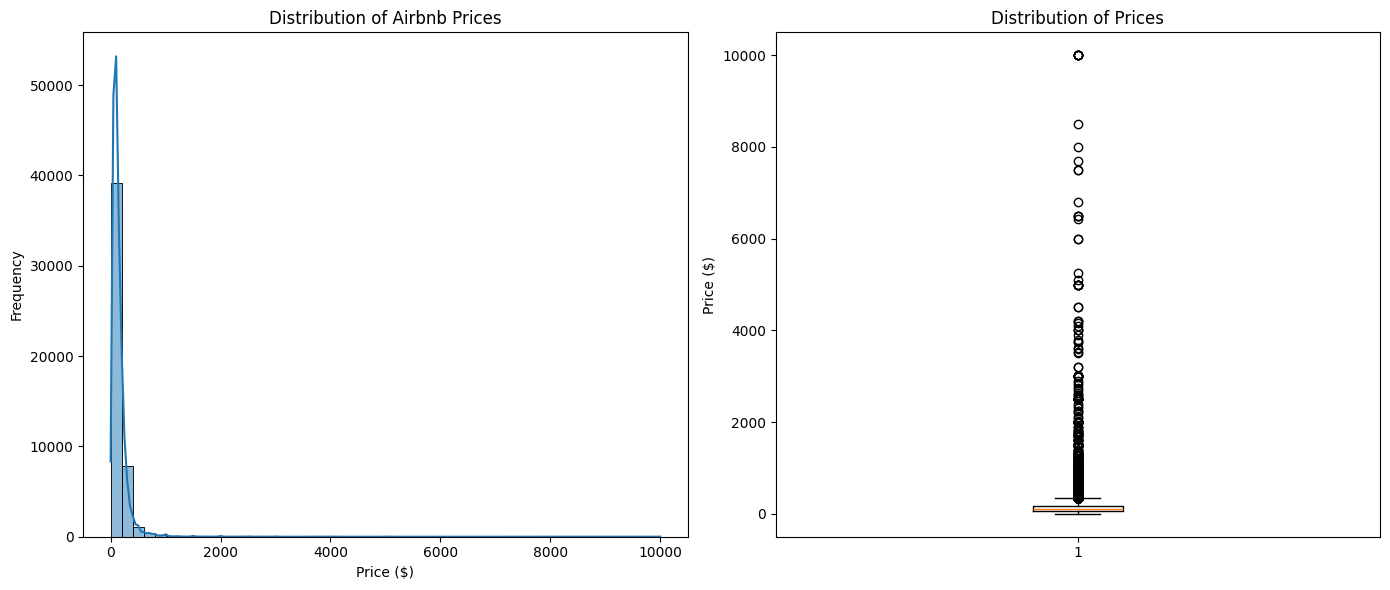

In [ ]:
# Distribution of Prices
def show_distribution():

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figure size as needed
    
    # Histogram
    sns.histplot(df['price'], bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Distribution of Airbnb Prices')
    axes[0].set_xlabel('Price ($)')
    axes[0].set_ylabel('Frequency')
    
    # Boxplot
    axes[1].boxplot(df['price'])
    axes[1].set_title('Distribution of Prices')
    axes[1].set_ylabel('Price ($)')  # Optional, to match style
    
    plt.tight_layout()
    plt.show()

show_distribution()

As predicted from above, the distribution of prices is highly skewed and right-tailed, since there are a small number of listings with extremely high prices compared to the majority of listings clustered at lower price points. This heavy skewness suggests that a few very expensive properties are stretching the distribution toward the right, while most listings are priced at a more modest range. As a result, the mean price is pulled upward by these extreme values, making the median a potentially more reliable measure of central tendency for this dataset. Hence, this observation indicates the need for appropriate handling of outliers.

##### 6.2 Data Preprocessing

In [ ]:
# Handling missing values
# Fill missing reviews_per_month with 0, as no review means 0 per month
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [ ]:
# Convert last_review to datetime
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

In [ ]:
df['last_review'].dtype

dtype('<M8[ns]')

In [ ]:
# Feature Engineering
# Create a new feature: days_since_last_review
df['days_since_last_review'] = (pd.Timestamp('2020-01-01') - df['last_review']).dt.days
## mention that the current date is set as the last day of 2019 since the dataset is from 2019

# Fill missing days_since_last_review with a large number (never reviewed)
df['days_since_last_review'] = df['days_since_last_review'].fillna(9999)

In the above code, I first handled the missing values in the reviews_per_month column by replacing them with 0, as the absence of values likely indicates that the listing had no reviews. To enable better operations and calculations involving dates, I then converted the last_review column into a proper datetime object. Following this, I created a new column called days_since_last_review, which represents the number of days between a reference date and the property's most recent review. Since the dataset is based on 2019 data, the "current date" used for this calculation was set to January 1, 2020, rather than today's actual date. Lastly, for listings that had missing values in the last_review column (meaning they had no reviews at all), I replaced the corresponding missing values in days_since_last_review with a very large number (9999). This was done to clearly distinguish properties with no review history from those with recent activity, ensuring that the model or subsequent analysis could appropriately account for listings that had never been reviewed.

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,439.0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,225.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,0.00,1,365,9999.0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,180.0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,408.0


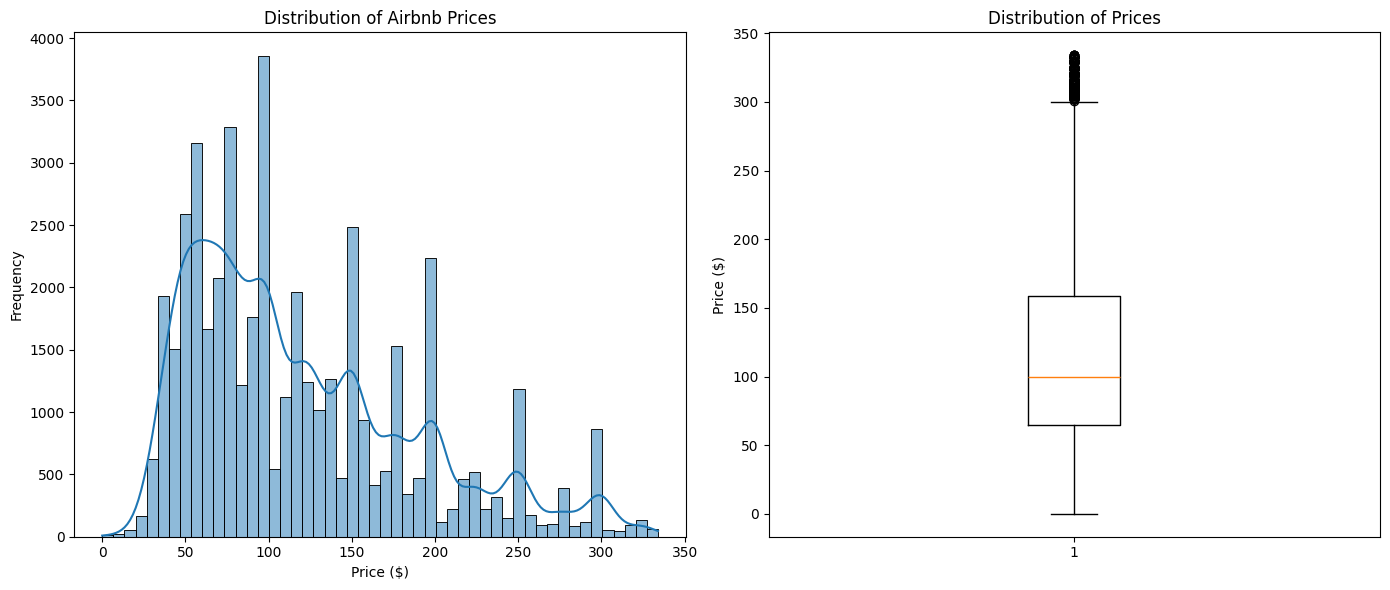

In [ ]:
# Remove outliers in price
Q1 = df['price'].quantile(0.25)  # 25th percentile
Q3 = df['price'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1

# Define "outliers" as points outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]

show_distribution()

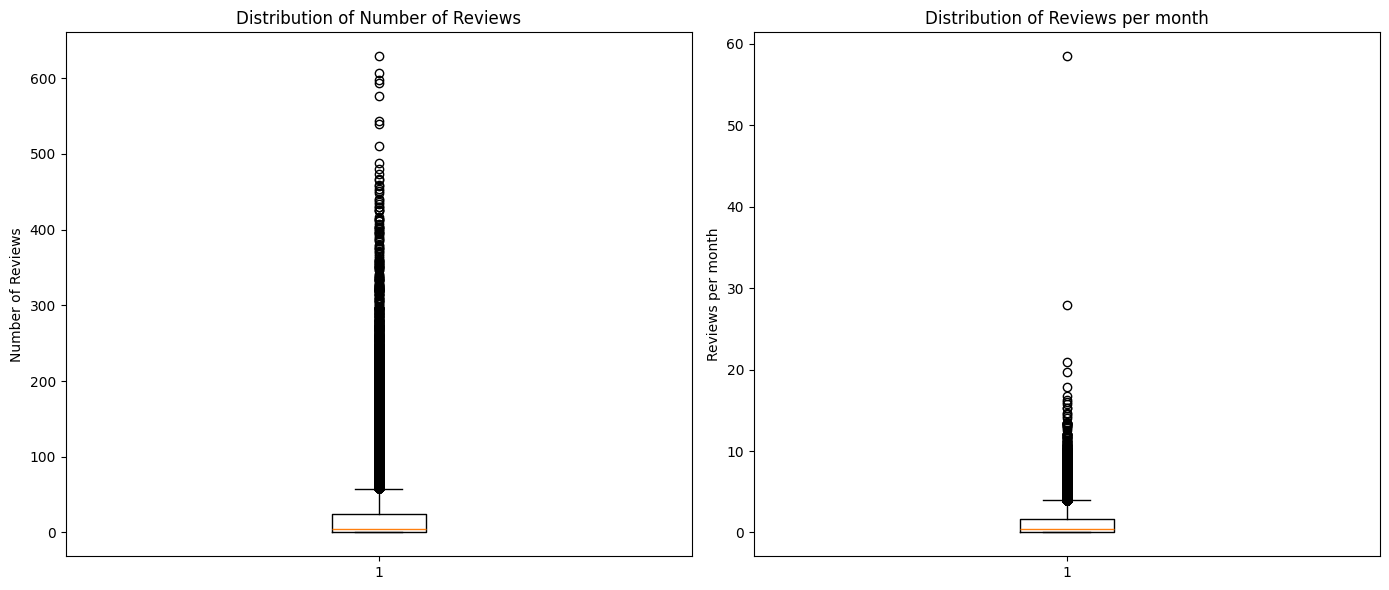

In [ ]:
def show_distribution_reviews():

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figure size as needed

    # Boxplot_number_of_reveiws
    axes[0].boxplot(df['number_of_reviews'])
    axes[0].set_title('Distribution of Number of Reviews')
    axes[0].set_ylabel('Number of Reviews') 

    # Boxplot_reviews_per_month
    axes[1].boxplot(df['reviews_per_month'])
    axes[1].set_title('Distribution of Reviews per month')
    axes[1].set_ylabel('Reviews per month') 
    
    plt.tight_layout()
    plt.show()

show_distribution_reviews()

In addition, the distribution for review-related columns was inspected as well. As seen from the above box plots, the distributions are very skewed, especially for the number of reviews, which shows a heavy concentration of data points at the lower end and a few extreme outliers at the higher end. This skewness suggests that most properties have only a small number of reviews, while a small number of listings have an exceptionally high number of reviews. Therefore, to ensure that the analysis is not disproportionately influenced by these extreme values, it is necessary to consider removing or treating outliers appropriately. Doing so can lead to more reliable insights and improve the robustness of any models built on this data.

In [ ]:
# Remove outliers in number_of_reviews
Q1_num_reviews = df['number_of_reviews'].quantile(0.25)  # 25th percentile
Q3_num_reviews = df['number_of_reviews'].quantile(0.75)  # 75th percentile
IQR_num_reviews = Q3 - Q1
df = df[(df['number_of_reviews'] >= Q1_num_reviews - 1.5 * IQR_num_reviews) & (df['number_of_reviews'] <= Q3_num_reviews + 1.5 * IQR_num_reviews)]

# Remove outliers in reviews_per_month
Q1_reviews_per_month = df['reviews_per_month'].quantile(0.25)  # 25th percentile
Q3_reviews_per_month = df['reviews_per_month'].quantile(0.75)  # 75th percentile
IQR_reviews_per_month = Q3 - Q1
df = df[(df['reviews_per_month'] >= Q1_reviews_per_month - 1.5 * IQR_reviews_per_month) & (df['reviews_per_month'] <= Q3_reviews_per_month + 1.5 * IQR_reviews_per_month)]

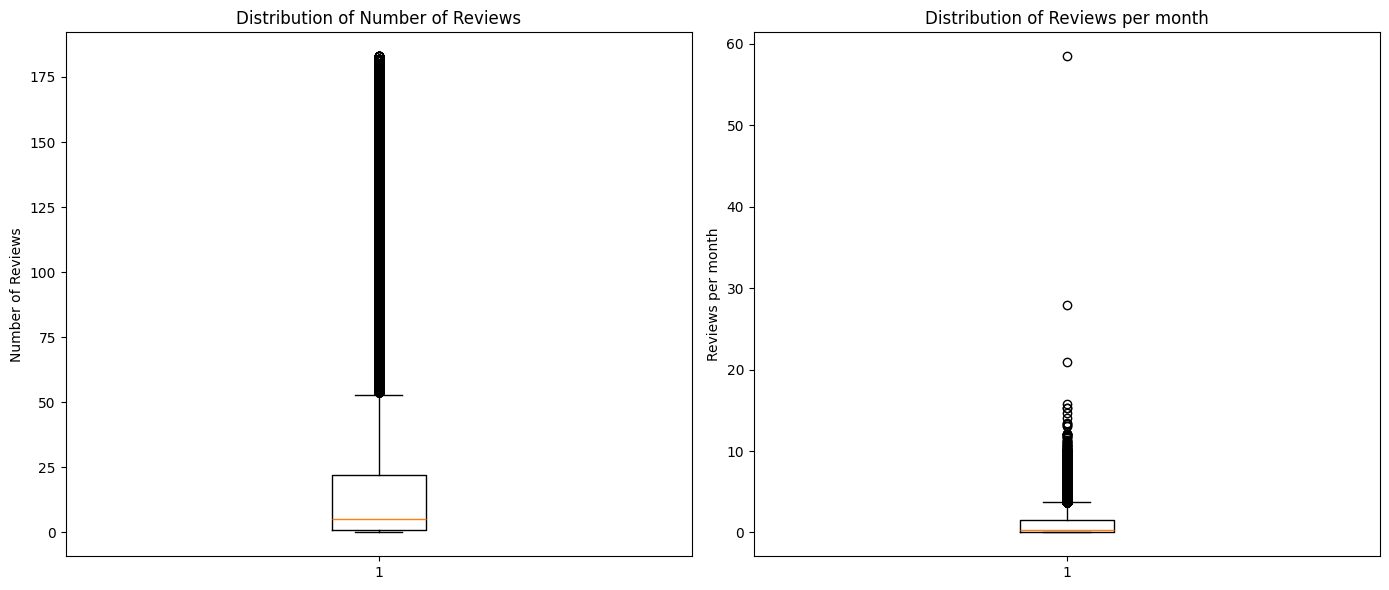

In [ ]:
show_distribution_reviews()

Compared to the previous box plots, we can see that the distribution for number of reviews has much stabilized.

In [ ]:
# Normalize data (price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, days_since_last_review)
df['price_norm']=skp.MinMaxScaler().fit_transform(df['price'].values.reshape(-1,1))
df['minimum_nights_norm']=skp.MinMaxScaler().fit_transform(df['minimum_nights'].values.reshape(-1,1))
df['number_of_reviews_norm']=skp.MinMaxScaler().fit_transform(df['number_of_reviews'].values.reshape(-1,1))
df['reviews_per_month_norm']=skp.MinMaxScaler().fit_transform(df['reviews_per_month'].values.reshape(-1,1))
df['calculated_host_listings_count_norm']=skp.MinMaxScaler().fit_transform(df['calculated_host_listings_count'].values.reshape(-1,1))
df['days_since_last_review_norm']=skp.MinMaxScaler().fit_transform(df['days_since_last_review'].values.reshape(-1,1))

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review,price_norm,minimum_nights_norm,number_of_reviews_norm,reviews_per_month_norm,calculated_host_listings_count_norm,days_since_last_review_norm
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,0.21,6,365,439.0,0.446108,0.000000,0.049180,0.003590,0.015337,0.026675
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,0.38,2,355,225.0,0.673653,0.000000,0.245902,0.006496,0.003067,0.004887
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,0.00,1,365,9999.0,0.449102,0.001601,0.000000,0.000000,0.000000,1.000000
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,0.10,1,0,408.0,0.239521,0.007206,0.049180,0.001709,0.000000,0.023519
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,0.59,1,129,193.0,0.598802,0.001601,0.404372,0.010085,0.000000,0.001629


##### 6.3 Statistical Tests

##### 6.3.1 Correlation Matrix

In [2]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['price_norm', 'number_of_reviews_norm', 'reviews_per_month_norm', 'days_since_last_review_norm' ]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

NameError: name 'plt' is not defined

##### 6.3.2 Bin test

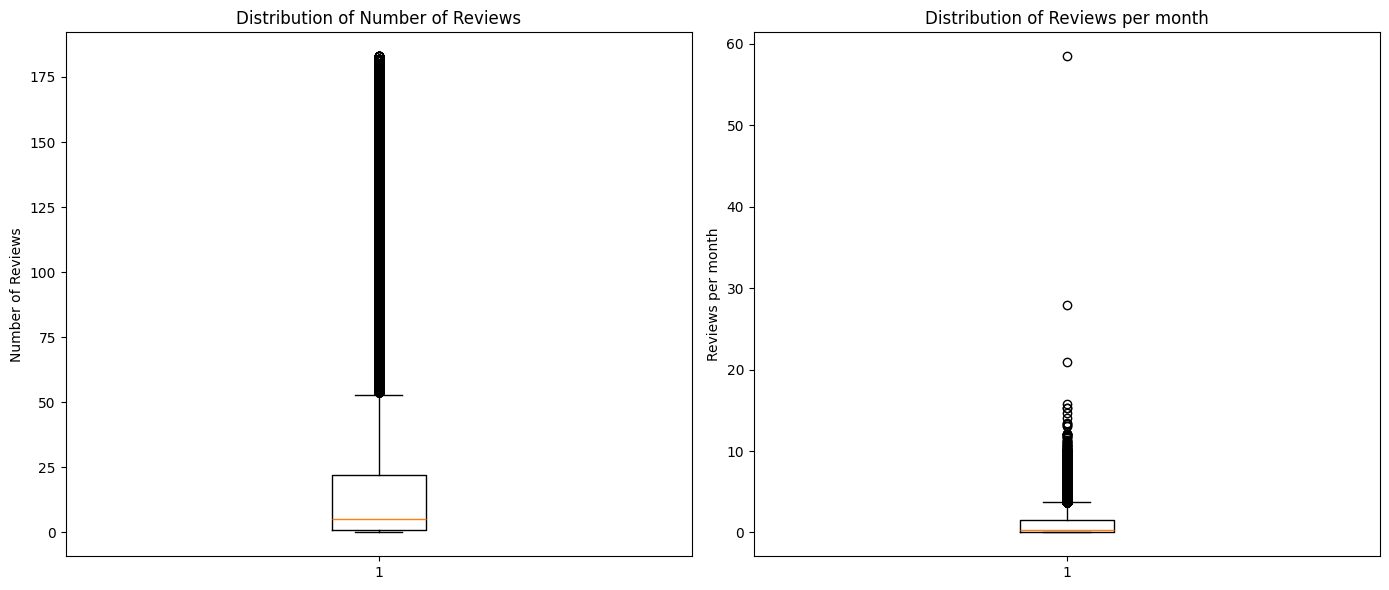

In [ ]:
show_distribution_reviews()

Since the number of reviews, reviews per month, and days since the last review are continuous variables, a bined analysis was conducted to split the values into smaller groups and observe their relationship to price. Prior to conducting the test, it is essential to examine the distribution of each column to create appropriate bins. Therefore, the box plot generated earlier was carefully observed, and bins were created based on the distribution characteristics. Specifically, the box plot revealed key points such as the lower whisker, median, and upper whisker, which guided the creation of bins that capture meaningful segments of the data. For example, in case of number of reviews most of the data (Interquartile range) are distributed between 0-25, so more bins were allocated within this range to cover the high density fo values.

Number of reviews

/var/folders/vl/_bk7s0kx0kj68y31shfy7s_m0000gn/T/ipykernel_71192/61048068.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_num_reviews = df.groupby('number_of_reviews_bin')['price'].mean()


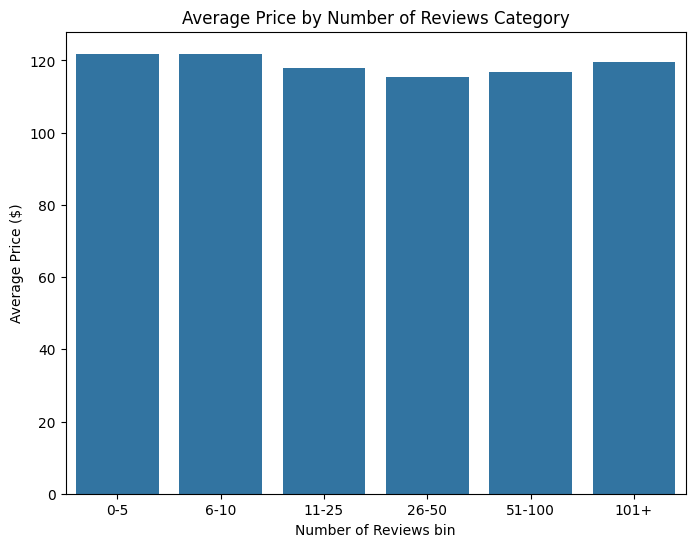

number_of_reviews_bin
0-5       121.872119
6-10      121.746205
11-25     118.039631
26-50     115.416101
51-100    116.771078
101+      119.474929
Name: price, dtype: float64

In [ ]:
bins = [0, 5, 10, 25, 50, 100, 200]
labels = ['0-5', '6-10', '11-25', '26-50', '51-100', '101+']
df['number_of_reviews_bin'] = pd.cut(df['number_of_reviews'], bins=bins, labels=labels, include_lowest=True)

# Grouped Mean Price by Number of reviews bin
grouped_num_reviews = df.groupby('number_of_reviews_bin')['price'].mean()

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=grouped_num_reviews.index, y=grouped_num_reviews.values)
plt.title('Average Price by Number of Reviews Category')
plt.xlabel('Number of Reviews bin')
plt.ylabel('Average Price ($)')
plt.show()

grouped_num_reviews

The grouped number of reviews indicates a relatively stable relationship between the number of reviews and the price across the different bins, with only slight variations observed as the number of reviews increases. 

#### Reviews per Month

/var/folders/vl/_bk7s0kx0kj68y31shfy7s_m0000gn/T/ipykernel_71192/2625937868.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_reviews_per_month = df.groupby('reviews_per_month_bin')['price'].mean()


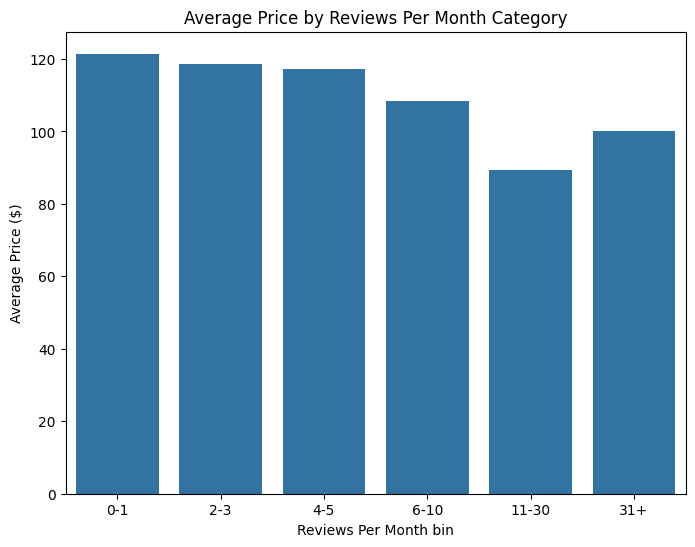

reviews_per_month_bin
0-1      121.444672
2-3      118.527543
4-5      117.120202
6-10     108.391833
11-30     89.478261
31+      100.000000
Name: price, dtype: float64

In [ ]:
bins = [0, 1, 3, 5, 10, 30, 60]
labels = ['0-1', '2-3', '4-5', '6-10', '11-30', '31+']
df['reviews_per_month_bin'] = pd.cut(df['reviews_per_month'], bins=bins, labels=labels, include_lowest=True)

# Grouped Mean Price by reviews per month bin
grouped_reviews_per_month = df.groupby('reviews_per_month_bin')['price'].mean()

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=grouped_reviews_per_month.index, y=grouped_reviews_per_month.values)
plt.title('Average Price by Reviews Per Month Category')
plt.xlabel('Reviews Per Month bin')
plt.ylabel('Average Price ($)')
plt.show()

grouped_reviews_per_month

The reviews_per_month bins show a more noticeable downward trend in price as the review frequency increases. The "0-1" bin, representing properties with the fewest reviews per month, has a price of 121.44 dollars, which is the highest among the bins. This could be due to listings that either receive few reviews due to their newness or because they are priced higher but are not as frequently booked. As we move to the higher bins, such as "2-3" (118.53 dollars) and "4-5" (117.12 dollars), the prices gradually decrease, with the most significant drop occurring in the "6-10" bin, where prices fall to 108.39 dollars. Properties in this range may be experiencing more consistent bookings, but possibly at a lower price point. The lowest prices are observed in the "11-30" and "31+" bins, where prices are 89.48 and 100.00 dollars, respectively. This suggests that properties with a higher frequency of reviews (indicating frequent bookings) may be associated with lower prices, possibly due to discounts, promotions, or greater competition in the marketplace.

#### Days since last review

/var/folders/vl/_bk7s0kx0kj68y31shfy7s_m0000gn/T/ipykernel_71192/3288143306.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_days_since_last_review = df.groupby('days_since_last_review_bin')['price'].mean()


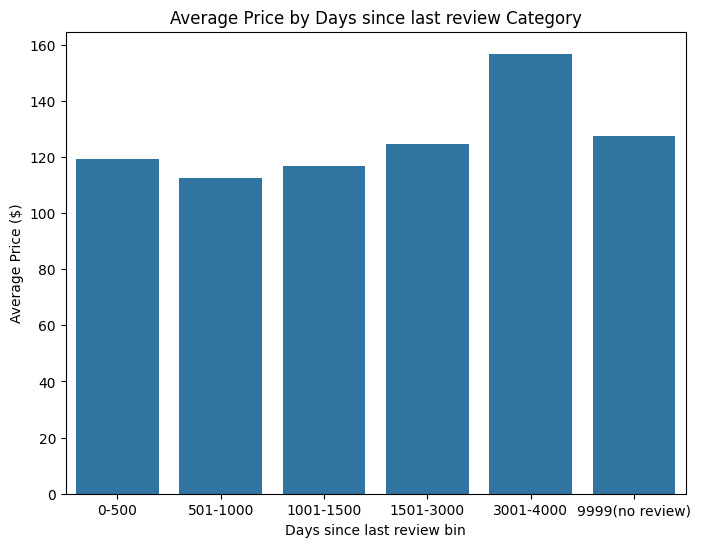

days_since_last_review_bin
0-500              119.311416
501-1000           112.562018
1001-1500          116.925315
1501-3000          124.462977
3001-4000          156.800000
9999(no review)    127.425211
Name: price, dtype: float64

In [ ]:
bins = [0, 500, 1000, 1500, 3000, 4000, 10000]
labels = ['0-500', '501-1000', '1001-1500', '1501-3000', '3001-4000', '9999(no review)']
df['days_since_last_review_bin'] = pd.cut(df['days_since_last_review'], bins=bins, labels=labels, include_lowest=True)

# Grouped Mean Price by Number of reviews bin
grouped_days_since_last_review = df.groupby('days_since_last_review_bin')['price'].mean()

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=grouped_days_since_last_review.index, y=grouped_days_since_last_review.values)
plt.title('Average Price by Days since last review Category')
plt.xlabel('Days since last review bin')
plt.ylabel('Average Price ($)')
plt.show()

grouped_days_since_last_review

The days_since_last_review bins show a varied relationship with price, with the lowest prices observed for the most recent reviews (indicating higher turnover or more active listings). The "0-500" range, where listings have reviews that are relatively recent, has a price of 119.31 dollars, suggesting that these properties tend to have higher prices. This could be because recent reviews often reflect high demand and better-maintained listings. As the days since the last review increase, prices slightly decrease in the "501-1000" bin to 112.5 dollars, and then rise again to 116.93 dollars in the "1001-1500" bin, reflecting a somewhat complex relationship between price and review recency. The higher prices in this range could indicate listings that have been around for a while but still maintain high value. The "1501-3000" range sees a significant price increase to 124.46 dollars, which could suggest that listings with older reviews may either have undergone significant improvements or represent desirable locations that retain higher value over time. However, the "3001-4000" range, with prices as high as 156.80 dollars, represents the highest price group, which likely indicates that properties with reviews further in the past could still have great value due to location or unique features. The "9999 (no review)" bin shows a price of $127.43, indicating that properties with no reviews, often classified as new or untested listings, still have a relatively high price. This might reflect properties that have not yet been reviewed but are priced attractively to draw in initial customers.

##### 6.4 Predictive Modeling

In [ ]:
# Selecting features
features = ['number_of_reviews_norm','reviews_per_month_norm', 'days_since_last_review_norm']
X = df[features]
y = df['price_norm']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print('Model Evaluation:')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'R2 Score: {r2_score(y_test, y_pred):.10f}')

Model Evaluation:
MAE: 0.17
R2 Score: 0.0035476892


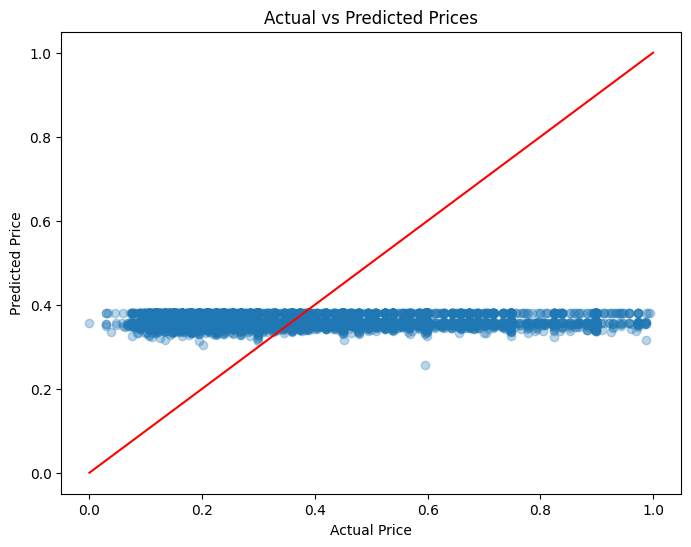

In [ ]:
# Visualization of Prediction Performance
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0,1], [0,1], color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


## 7. Insights & Recommendations


///

## Extra Credit: Modeling (keyword analysis from property names)

In addition to analyzing numerical features, I conducted a keyword analysis on the property names to explore whether specific words are associated with variations in listing prices. Since property names often highlight key selling points or features — such as "luxury," "cozy," or "spacious" — understanding the language used could offer insights into how hosts market their properties and how that, in turn, relates to pricing strategies. This approach aims to capture qualitative signals from the dataset and examine their potential influence on price.

#### Methodology:
To perform the analysis, I first preprocessed the name column by tokenizing the text into individual words. I used CountVectorizer to transform the words into a numerical feature matrix, where each column represents a unique word and each row reflects the word counts for a listing. This allowed the text data to be represented in a machine-learning-friendly format. I then trained a Linear Regression model, using the word features as input and the listing prices as the target variable. By examining the learned model coefficients, I assessed the relationship between the presence of specific words and their corresponding influence on price — identifying which keywords tend to be associated with higher or lower pricing.

In [ ]:
#Preprocess the 'name' column
df['name'] = df['name'].fillna('')  # Handle missing values
df['name'] = df['name'].str.lower()  # Lowercase

In [ ]:
#Feature extraction: Convert names into word features
vectorizer = CountVectorizer(stop_words='english')  # Remove common stopwords automatically
X = vectorizer.fit_transform(df['name'])  # X is a sparse matrix

In [ ]:
#Target variable
y = df['price']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train a model
model = LinearRegression()
model.fit(X_train, y_train)

#Predict
y_pred = model.predict(X_test)

In [ ]:
#Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")

#Analyze word importance
#(The coefficients tell you which words are associated with higher/lower prices)
feature_names = vectorizer.get_feature_names_out()
coef_df = pd.DataFrame({'word': feature_names, 'coefficient': model.coef_})
coef_df = coef_df.sort_values('coefficient', ascending=False)

print(coef_df.head(10))  # Words most positively associated with price
print(coef_df.tail(10))  # Words most negatively associated with price

R² Score: 0.3275
Mean Absolute Error: 42.34
              word  coefficient
5789          seas   304.288580
712           5131   277.346028
2211  close2subway   240.420595
5413        quartz   240.402424
5498      redbrick   236.561632
1104      acogedor   232.442645
192            181   230.937362
5060      parkways   229.190926
6324     sunlights   226.079426
720           5143   224.878226
             word  coefficient
1251  apartamento  -153.470634
6087         spce  -156.576790
6161        start  -158.490441
4889       nyct02  -158.872539
4640       moment  -183.349661
3356   glittering  -187.840572
4698       mtrain  -217.331301
5431       quiete  -253.756364
5611       rincón  -270.935602
4272        lugar  -298.300039


#### Results and interpretation:

The linear regression model achieved an R² score of 0.3275, indicating that approximately 32.75% of the variance in property prices can be explained by the presence of specific words in the listing names. The model's mean absolute error (MAE) was 42.34, meaning that on average, the predicted prices deviated from the actual prices by about $42.34.

By examining the learned coefficients, we can identify which words are most strongly associated with price increases or decreases. Words such as "seas," "close2subway," "sunlights," and "redbrick" showed the highest positive coefficients, suggesting that listings containing these keywords tend to have higher prices. Seas, close2subway, sunlights are words that imply desirable locations and good quality, which makes sense in the context of higher prices. Generally, properties near the sea, with good sunlight, or in areas with good transportation links are priced higher.

Conversely, words like "lugar," "rincón," "quiete," "apartmento," and "glittering" had the most negative coefficients, indicating that their presence is associated with lower listing prices. Some of these negatively correlated terms may relate to smaller spaces, less convenient locations, or marketing language that does not translate into perceived value. For example, "apartamento" (which means apartment in Spanish) is often associated with smaller sizes and less privacy compared to standalone houses, making it likely to be correlated with lower prices. Additionally, there seems to be more Spanish words on the negative coefficient side, suggesting that language or the host's nationality could also be related to price. However, this connection is difficult to confirm solely based on the current results, and further research would be needed to investigate this potential correlation more thoroughly.

Overall, the analysis demonstrates that keywords embedded in property names carry meaningful signals about pricing, reinforcing the idea that language choices in marketing materials can influence customer perceptions and market positioning.

#### Limitation:

While the keyword analysis provides valuable insights, there are several limitations to consider. First, the relatively modest R² score suggests that while words contribute to price variance, a large portion of the variability is driven by other factors not captured by listing names alone — such as location, property size, amenities, and seasonal demand. Additionally, CountVectorizer treats words independently and does not capture context, nuance, or word combinations that may better explain pricing trends. Some words with strong coefficients might also appear infrequently, leading to unstable estimates. Finally, because the model assumes linear relationships, it may oversimplify more complex patterns between language and pricing. Future analysis could improve on these aspects by incorporating n-grams, using more sophisticated text representations (e.g., TF-IDF or embeddings), or combining text features with additional property metadata.

#### Analysis 7: Neighborhood/Neighborhood Group

In [ ]:
# load data
df = pd.read_csv('AB_NYC_2019.csv')

# show basic info and first few rows of the data
print(df.info())
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Data Cleaning

In [ ]:
# 1) outlier detection using IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# apply IQR filtering
df_iqr = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# 2) add parent-child relation flag: verify neighborhoods within groups
neigh_check = df_iqr.groupby(['neighbourhood_group', 'neighbourhood']).size().reset_index(name='count')

# 3) standardization & normalization for later use

scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

numerical_cols = ['minimum_nights', 'availability_365', 'price']
df_standard = df.copy()
df_standard[numerical_cols] = scaler_standard.fit_transform(df_standard[numerical_cols])

df_normalized = df.copy()
df_normalized[numerical_cols] = scaler_minmax.fit_transform(df_normalized[numerical_cols])

# Label Encoding for categorical variables
for col in ['neighbourhood_group', 'neighbourhood', 'room_type']:
    le = LabelEncoder()
    df_standard[col] = le.fit_transform(df_standard[col])
    df_normalized[col] = le.fit_transform(df_normalized[col])

# check
neigh_check

,neighbourhood_group,neighbourhood,count
0,Bronx,Allerton,41
1,Bronx,Baychester,7
2,Bronx,Belmont,24
3,Bronx,Bronxdale,19
4,Bronx,Castle Hill,9
...,...,...,...
214,Staten Island,Tompkinsville,42
215,Staten Island,Tottenville,7
216,Staten Island,West Brighton,18
217,Staten Island,Westerleigh,2


### Exploratory Data Analysis (EDA)


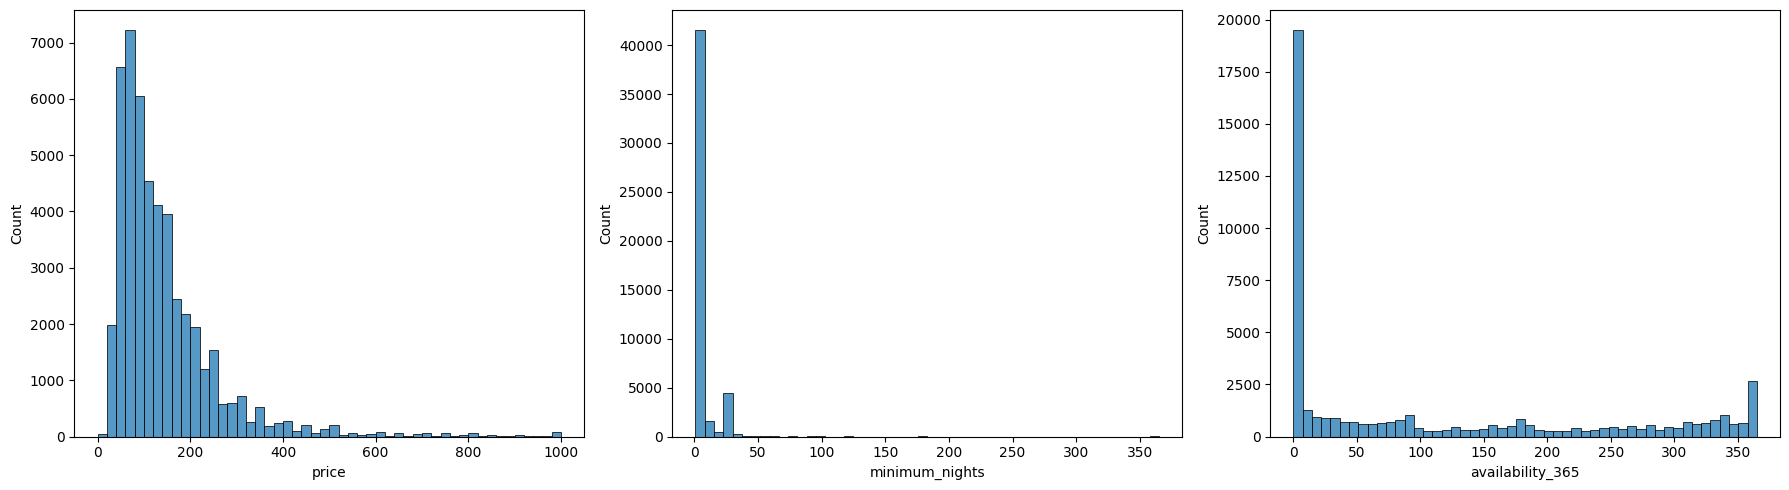

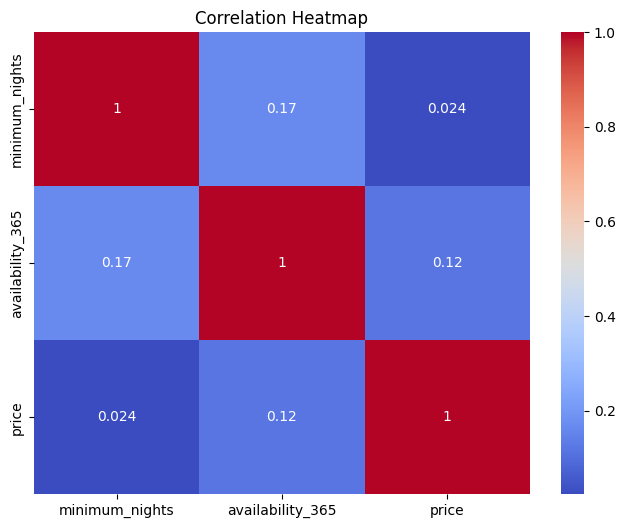

In [ ]:
# Histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['price'], bins=50, ax=axs[0])
sns.histplot(df['minimum_nights'], bins=50, ax=axs[1])
sns.histplot(df['availability_365'], bins=50, ax=axs[2])
plt.tight_layout()
plt.show()

numerical_cols = ['minimum_nights', 'availability_365', 'price']
# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

##### (1) group mean price comparison

In [ ]:
mean_prices_group = df.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)
mean_prices_neigh = df.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean()
print('Average Price of Neighborhood Groups:', mean_prices_group)
print()
print('Average Price of Neighborhoods', mean_prices_neigh)

Average Price of Neighborhood Groups: neighbourhood_group
Manhattan        178.934413
Brooklyn         117.819298
Staten Island     98.584906
Queens            94.983021
Bronx             85.283486
Name: price, dtype: float64

Average Price of Neighborhoods neighbourhood_group  neighbourhood
Bronx                Allerton          87.595238
                     Baychester        75.428571
                     Belmont           77.125000
                     Bronxdale         57.105263
                     Castle Hill       63.000000
                                         ...    
Staten Island        Tottenville      144.857143
                     West Brighton     80.555556
                     Westerleigh       71.500000
                     Willowbrook      249.000000
                     Woodrow          700.000000
Name: price, Length: 221, dtype: float64


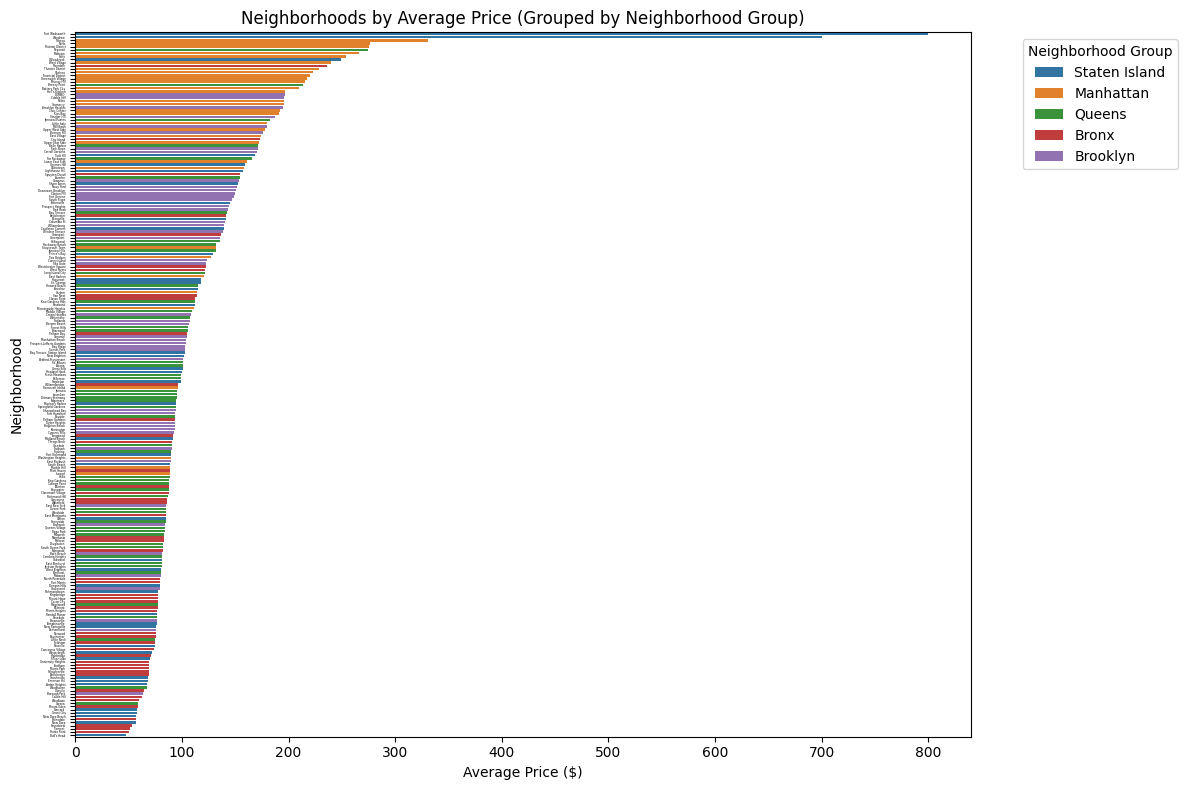

,neighbourhood_group,neighbourhood,price
188,Staten Island,Fort Wadsworth,800.000000
220,Staten Island,Woodrow,700.000000
121,Manhattan,Tribeca,330.393939
115,Manhattan,NoHo,276.246753
102,Manhattan,Flatiron District,275.052632
163,Queens,Neponsit,274.666667
112,Manhattan,Midtown,265.703607
118,Manhattan,SoHo,254.342857
219,Staten Island,Willowbrook,249.000000
126,Manhattan,West Village,239.493369


In [ ]:
# grouped mean price by neighbourhood group AND neighbourhood
grouped_neigh_combined = df.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean().reset_index()

# sort by price descending
grouped_neigh_combined = grouped_neigh_combined.sort_values('price', ascending=False)

# plot
plt.figure(figsize=(12,8))
sns.barplot(x='price',y='neighbourhood', hue='neighbourhood_group',data=grouped_neigh_combined,dodge=False)

plt.title('Neighborhoods by Average Price (Grouped by Neighborhood Group)')
plt.xlabel('Average Price ($)')
plt.ylabel('Neighborhood')
plt.yticks(fontsize=2)
plt.legend(title='Neighborhood Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# show the 15 most expensive neighborhood
grouped_neigh_combined.head(15)

In general, Manhattan is significantly more expensive than the other boroughs. Among the neighborhoods, Fort Wadsworth and Woodrow in Staten Island appear unusually high in price; however, this may be attributed to small sample sizes. Conversely, the Bronx tends to be the least expensive borough overall.

##### (2) ANOVA Test

In [ ]:

# ANOVA: Does average price differ significantly by neighbourhood group?
groups = [df[df['neighbourhood_group'] == group]['price'] for group in df['neighbourhood_group'].unique()]
anova_neigh_group = f_oneway(*groups)

anova_neigh_group

F_onewayResult(statistic=np.float64(1159.3181110641706), pvalue=np.float64(0.0))

In the ANOVA test, we aim to determine whether the average listing price differs significantly by neighborhood group. The null hypothesis states that there is no difference in average prices across neighborhood groups and neighborhoods. For the neighborhood group variable, the p-value is 0 and the F-statistic is 1159.32, indicating a highly significant difference in average prices among the groups. This result suggests that location plays a major role in determining the price of an Airbnb listing.

#### Analysis 8: Minimum nights

##### (1) scatter plot

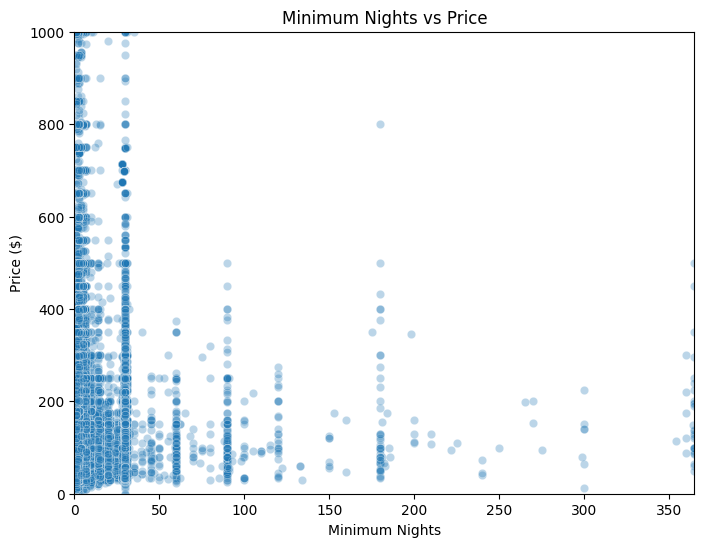

In [ ]:
# scatter plot of minimum nights vs. price
plt.figure(figsize=(8,6))
sns.scatterplot(x='minimum_nights', y='price', data=df, alpha=0.3)
plt.title('Minimum Nights vs Price')
plt.xlabel('Minimum Nights')
plt.ylabel('Price ($)')
plt.xlim(0, 365)  
plt.ylim(0, 1000)
plt.show()

The scatterplot reveals no strong visible trend between minimum night requirements and listing prices. Listings with very short minimum stays (1–3 nights) exhibit a wide price range, including both low and high prices. Similarly, listings with longer minimum night requirements also span a broad range of prices, indicating that the length of the minimum stay does not consistently predict the listing price.

##### (2) correlation

In [ ]:
X_min_nights = df[['minimum_nights']]
y_price = df['price']
reg_min_nights = LinearRegression().fit(X_min_nights, y_price)

In [ ]:
# get coefficient and intercept
slope = reg_min_nights.coef_[0]
intercept = reg_min_nights.intercept_

# print the regression equation
print('Regression equation: y =', slope, '* x +', intercept)

Regression equation: y = 0.17244254305368223 * x + 140.11121998395998


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


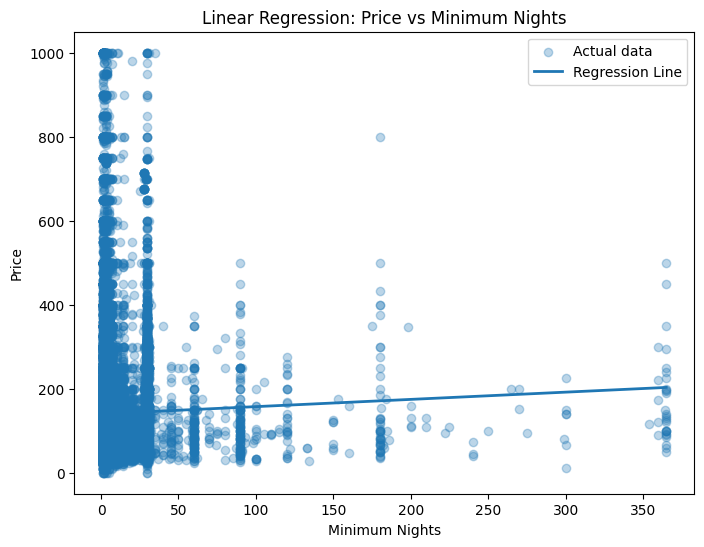

In [ ]:
# scatter plot of the actual data
plt.figure(figsize=(8,6))
plt.scatter(X_min_nights, y_price, alpha=0.3, label='Actual data')

# line plot of the regression prediction
X_range = np.linspace(X_min_nights.min(), X_min_nights.max(), 100).reshape(-1,1)
y_predicted = reg_min_nights.predict(X_range)
plt.plot(X_range, y_predicted, label='Regression Line', linewidth=2)

# labels and title
plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.title('Linear Regression: Price vs Minimum Nights')
plt.legend()
plt.show()


In [ ]:
# add a constant (intercept) term to X
X_min_nights_with_const = sm.add_constant(X_min_nights)

# fit the OLS (ordinary least squares) regression
model = sm.OLS(y_price, X_min_nights_with_const).fit()

# summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     27.60
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           1.50e-07
Time:                        14:16:54   Log-Likelihood:            -3.0054e+05
No. Observations:               48642   AIC:                         6.011e+05
Df Residuals:                   48640   BIC:                         6.011e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            140.1112      0.574    244.

The regression analysis shows a slope of 0.17, indicating that for each additional night added to the minimum stay requirement, the listing price increases by approximately $0.17 on average. This suggests that listings with higher minimum night requirements tend to have slightly higher prices, though the effect is very small. Despite the minimal impact, the p-value for the minimum nights variable is 0, which means the slope is statistically significant. Therefore, while the practical influence is limited, the relationship between minimum stay requirements and price is statistically meaningful.

##### (3) Binned Analysis

/var/folders/7d/_n326km93lxclrv58s18_wdm0000gn/T/ipykernel_35805/1510500550.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_min_nights = df.groupby('min_nights_bin')['price'].mean()


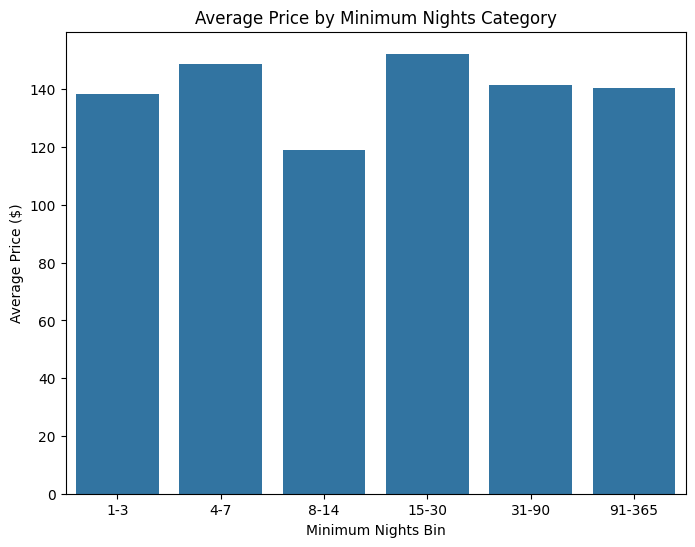

min_nights_bin
1-3       138.447285
4-7       148.604585
8-14      119.007003
15-30     152.320383
31-90     141.393657
91-365    140.508772
Name: price, dtype: float64

In [ ]:
# bin minimum nights
bins = [0, 3, 7, 14, 30, 90, 365]
labels = ['1-3', '4-7', '8-14', '15-30', '31-90', '91-365']
df['min_nights_bin'] = pd.cut(df['minimum_nights'], bins=bins, labels=labels)

# grouped mean price by minimum nights bin
grouped_min_nights = df.groupby('min_nights_bin')['price'].mean()

# plot
plt.figure(figsize=(8,6))
sns.barplot(x=grouped_min_nights.index, y=grouped_min_nights.values)
plt.title('Average Price by Minimum Nights Category')
plt.xlabel('Minimum Nights Bin')
plt.ylabel('Average Price ($)')
plt.show()

grouped_min_nights

Listings that require a minimum stay of 4–7 nights or 15–30 nights tend to have slightly higher prices. However, the difference in price across different minimum night categories remains modest and does not appear to be a dominant factor. Overall, the minimum nights requirement has only a weak impact on listing price.

##### (4) Clustering Listings by Minimum Nights

In [ ]:
X_clust_min = df[['minimum_nights', 'price']]
scores_min = {}
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_clust_min)
    scores_min[k] = silhouette_score(X_clust_min, kmeans.labels_)

best_k_min = max(scores_min, key=scores_min.get)
kmeans_min = KMeans(n_clusters=best_k_min, random_state=42).fit(X_clust_min)

print('Best number of clusters (k):', best_k_min)


Best number of clusters (k): 2


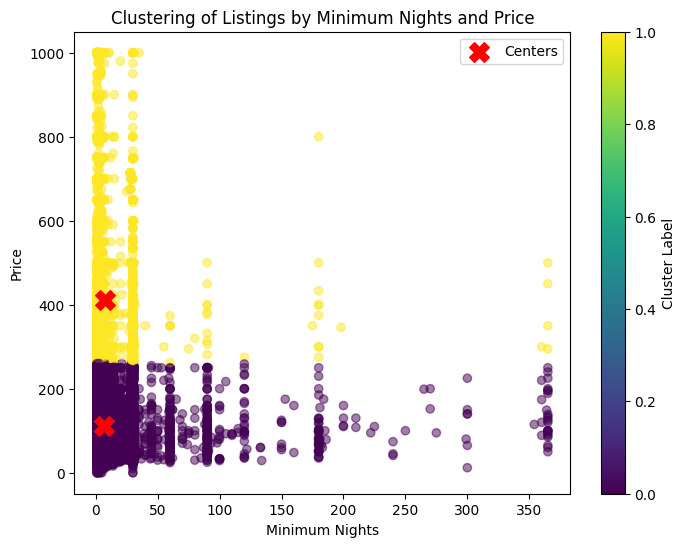

In [ ]:
# scatter plot with clusters
plt.figure(figsize=(8,6))
plt.scatter(X_clust_min['minimum_nights'], X_clust_min['price'], 
            c=kmeans_min.labels_, cmap='viridis', alpha=0.5)

# plot the cluster centers
centers = kmeans_min.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=200, marker='X', label='Centers')

plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.title('Clustering of Listings by Minimum Nights and Price')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()


Based on the silhouette scores, the optimal number of clusters is k = 2, indicating that Airbnb listings naturally form two distinct groups when considering minimum night requirements and price together. Each cluster represents listings with similar pricing levels and minimum stay policies. The red "X" markers on the plot indicate the center of each cluster, providing a rough estimate of the typical price and minimum nights for that group. From the clustering results, it is evident that while the two clusters differ significantly in price, both span a wide range of minimum night requirements. This suggests that minimum night requirements have little correlation with listing prices.

#### Analysis 9: Room Type Impact

##### (1) Grouped Mean Price

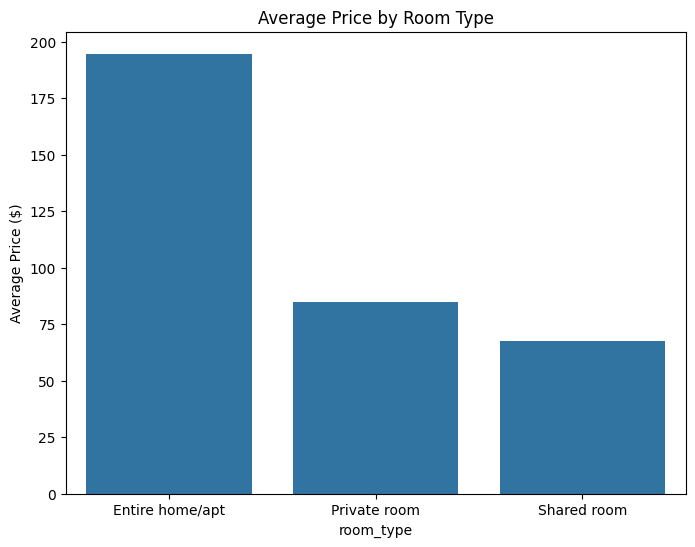

In [ ]:
grouped_room_type = df.groupby('room_type')['price'].mean().sort_values(ascending=False)

# plot
plt.figure(figsize=(8,6))
sns.barplot(x=grouped_room_type.index, y=grouped_room_type.values)
plt.title('Average Price by Room Type')
plt.ylabel('Average Price ($)')
plt.show()

##### (2) ANOVA Test for Room Type

In [ ]:
# ANOVA Test for Room Type
groups_room_type = [df[df['room_type'] == rt]['price'] for rt in df['room_type'].unique()]
anova_room_type = f_oneway(*groups_room_type)

grouped_room_type, anova_room_type

(room_type
 Entire home/apt    194.603316
 Private room        84.765802
 Shared room         67.578220
 Name: price, dtype: float64,
 F_onewayResult(statistic=np.float64(7057.457914422446), pvalue=np.float64(0.0)))

Entire apartments are priced significantly higher than private or shared rooms, with prices dropping sharply when only part of a place is being rented. This pattern is strongly supported by the results of the ANOVA test, which shows an F-statistic of 7057.46 and a p-value of 0. These values provide strong evidence that room type has a significant effect on listing price.

##### (3) Regression

In [ ]:
X_room = pd.get_dummies(df['room_type'], drop_first=True)
y_room = df['price']
reg_room = LinearRegression().fit(X_room, y_room)

In [ ]:
# get coefficients and intercept
intercept = reg_room.intercept_
coefficients = reg_room.coef_

# match coefficient names with dummy columns
coef_table = pd.DataFrame({
    'Room Type': X_room.columns,
    'Coefficient': coefficients
})

# print intercept
print('Intercept:', intercept)

# print coefficients for each room type
print(coef_table)

Intercept: 194.60331627592424
      Room Type  Coefficient
0  Private room  -109.837515
1   Shared room  -127.025097


In the regression model, the category "Entire home/apt" is omitted to avoid multicollinearity, serving as the reference category. Its effect is captured in the intercept, which is 194.6 -— representing the average price for an entire home or apartment when the dummy variables for private and shared rooms are both zero. The model follows the structure:

**Price = Intercept + (Private Room Coefficient × Private Room Dummy) + (Shared Room Coefficient × Shared Room Dummy).**

According to the results, private rooms are on average $109.84 less expensive than entire homes/apartments, while shared rooms are $127.03 cheaper. This further confirms that renting an entire place is substantially more expensive than renting a private or shared room.

#### Analysis 10: Availability Impact on Price

##### (1) Scatter plot of availability vs. price

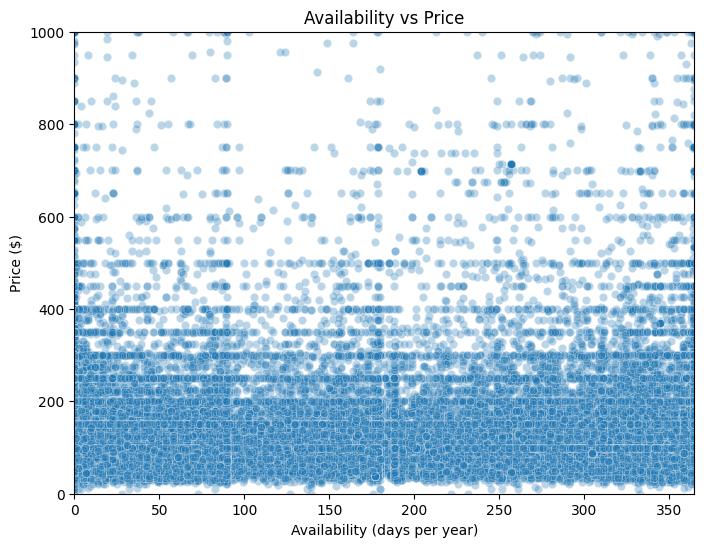

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='availability_365', y='price', data=df, alpha=0.3)
plt.title('Availability vs Price')
plt.xlabel('Availability (days per year)')
plt.ylabel('Price ($)')
plt.xlim(0, 365)
plt.ylim(0, 1000)
plt.show()

##### (2) regression

In [ ]:
X_avail = df[['availability_365']]
reg_avail = LinearRegression().fit(X_avail, y_price)

Regression equation: y = 0.10473125528500124 * x + 129.50980066430083


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


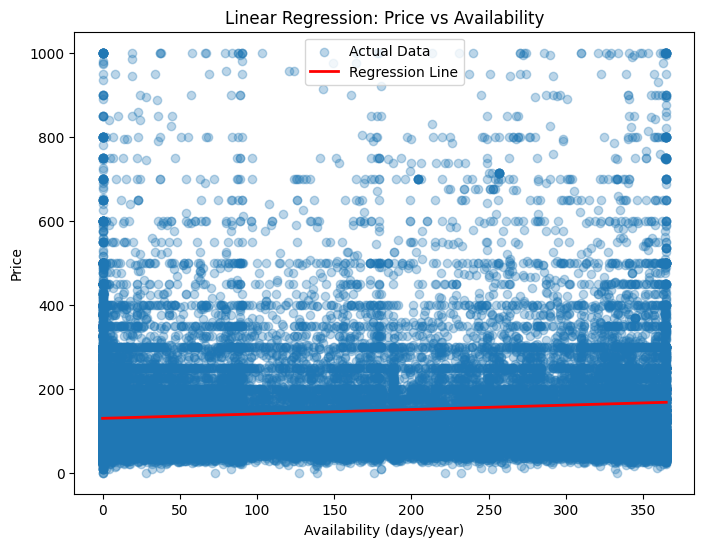

In [ ]:
# slope and intercept
slope = reg_avail.coef_[0]
intercept = reg_avail.intercept_

print('Regression equation: y =', slope, '* x +', intercept)

# scatter plot of the real data
plt.figure(figsize=(8,6))
plt.scatter(X_avail, y_price, alpha=0.3, label='Actual Data')

# create a line for the regression
X_range = np.linspace(X_avail.min(), X_avail.max(), 100).reshape(-1,1)
y_pred = reg_avail.predict(X_range)

# plot regression line
plt.plot(X_range, y_pred, color='red', label='Regression Line', linewidth=2)

# labels and title
plt.xlabel('Availability (days/year)')
plt.ylabel('Price')
plt.title('Linear Regression: Price vs Availability')
plt.legend()
plt.show()


In [ ]:
X_avail_with_const = sm.add_constant(X_avail)

# fit the OLS regression
model_avail = sm.OLS(y_price, X_avail_with_const).fit()

# show the summary
print(model_avail.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     685.4
Date:                Sat, 26 Apr 2025   Prob (F-statistic):          4.94e-150
Time:                        14:18:20   Log-Likelihood:            -3.0021e+05
No. Observations:               48642   AIC:                         6.004e+05
Df Residuals:                   48640   BIC:                         6.004e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              129.5098      0.692  

##### (3) Binned Analaysis

/var/folders/7d/_n326km93lxclrv58s18_wdm0000gn/T/ipykernel_35805/819013109.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_availability = df.groupby('availability_bin')['price'].mean()


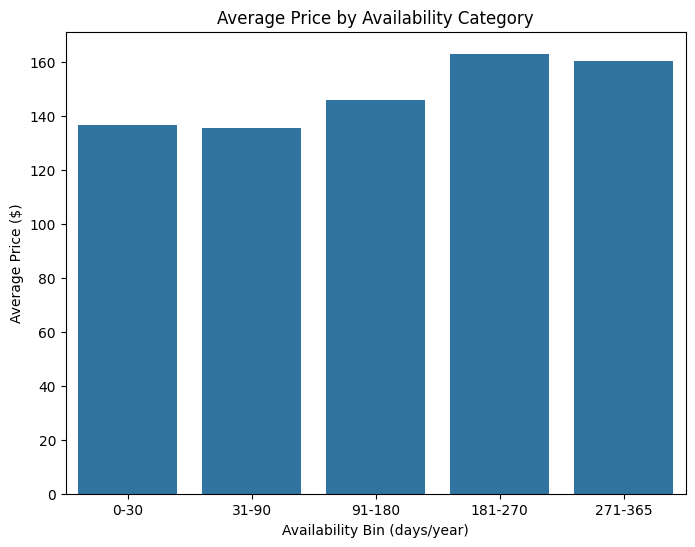

availability_bin
0-30       136.394607
31-90      135.470304
91-180     145.928069
181-270    162.883467
271-365    160.275943
Name: price, dtype: float64

In [ ]:
# Method 3: Binned Analysis
bins_avail = [0, 30, 90, 180, 270, 365]
labels_avail = ['0-30', '31-90', '91-180', '181-270', '271-365']
df['availability_bin'] = pd.cut(df['availability_365'], bins=bins_avail, labels=labels_avail)

# Grouped Mean Price by Availability Bin
grouped_availability = df.groupby('availability_bin')['price'].mean()

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=grouped_availability.index, y=grouped_availability.values)
plt.title('Average Price by Availability Category')
plt.xlabel('Availability Bin (days/year)')
plt.ylabel('Average Price ($)')
plt.show()

grouped_availability

The scatterplot reveals no clear visual trend between availability and price, suggesting a weak relationship. However, the regression analysis shows a small positive coefficient of 0.1, indicating that more available listings tend to be priced slightly higher. Despite the weak effect, the p-value is 0, meaning the relationship is statistically significant and we can reject the null hypothesis that the slope is zero. Additionally, listings available for more than half the year (181–365 days) are, on average, $20–30 more expensive than those available only for a few weeks, further supporting this modest but significant association.

#### Analysis 11: Decision Tree Feature Importance

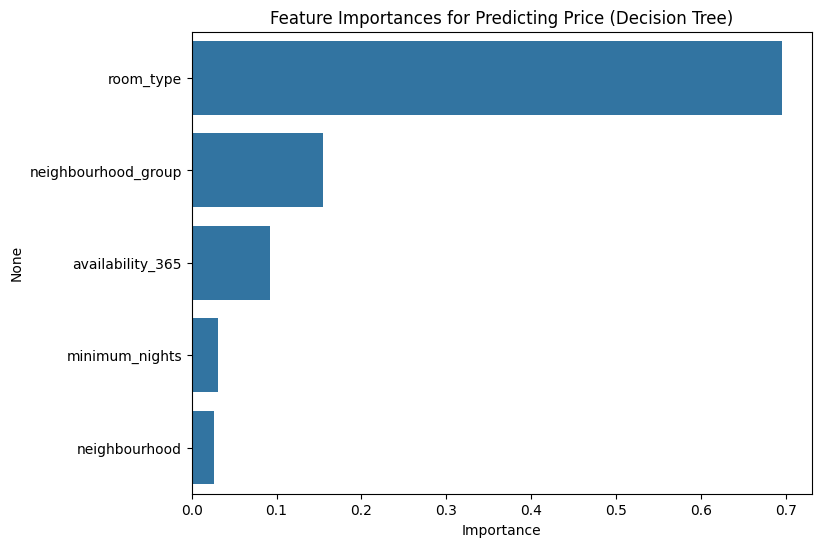

room_type              0.696051
neighbourhood_group    0.155002
availability_365       0.092437
minimum_nights         0.030453
neighbourhood          0.026058
dtype: float64

In [ ]:
# encode categorical variables
df_model = df[['neighbourhood_group', 'neighbourhood', 'room_type', 'minimum_nights', 'availability_365', 'price']].copy()
label_encoders = {}
for col in ['neighbourhood_group', 'neighbourhood', 'room_type']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# split data into train and test
X = df_model.drop('price', axis=1)
y = df_model['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train decision tree
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

# feature Importances
importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)

# plot
plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importances for Predicting Price (Decision Tree)')
plt.xlabel('Importance')
plt.show()

importances

Room type is the most important factor in predicting price, accounting for approximately 69% of the variation. While neighborhood group and availability have smaller impacts, their contributions are still non-trivial and cannot be ignored when evaluating listing prices.

### Predictive Modeling

In [ ]:
# define X and y for modeling
X_full = df_standard[['minimum_nights', 'availability_365', 'neighbourhood_group', 'room_type']]
y_full = df['price']

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# 1. linear regression
reg_full = LinearRegression()
reg_full.fit(X_train, y_train)
y_pred_reg = reg_full.predict(X_test)

# 2. KNN regression
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# 3. decision tree regression
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)


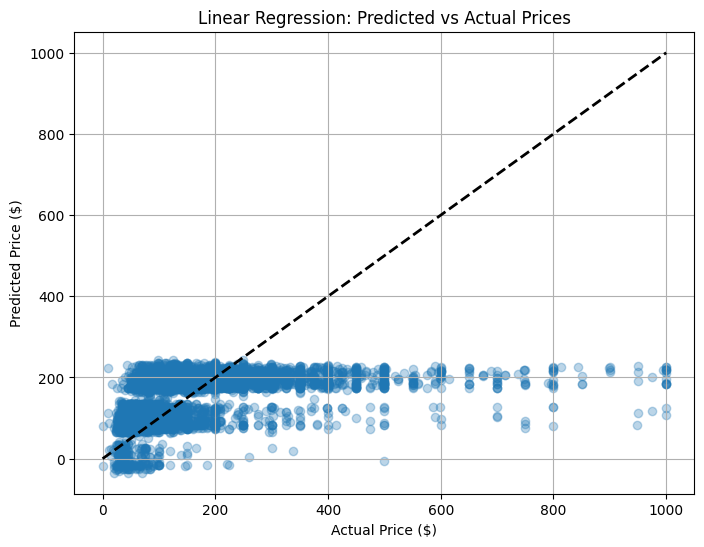

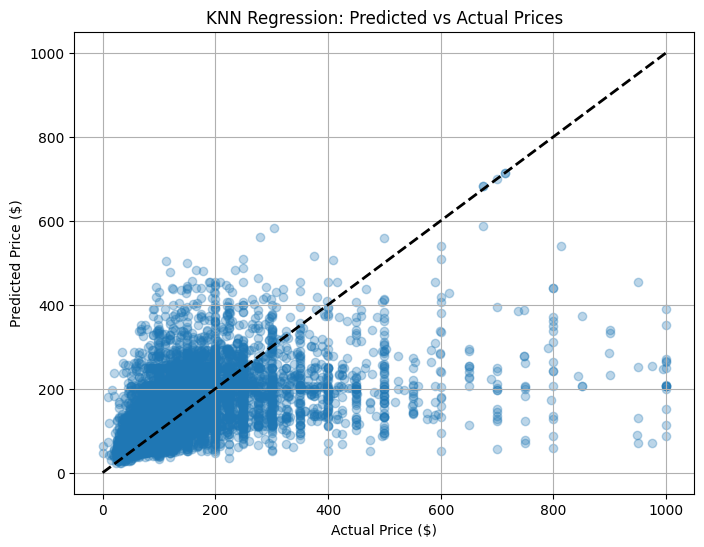

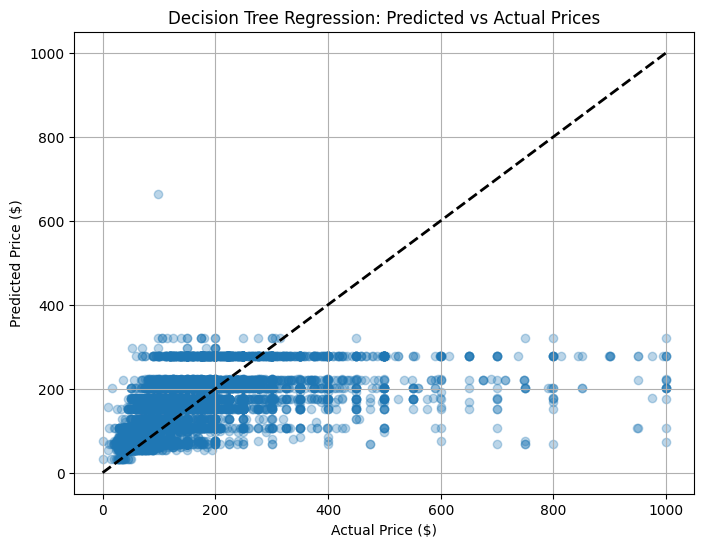

In [ ]:
# plotting function
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.title(f'{model_name}: Predicted vs Actual Prices')
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.grid(True)
    plt.show()

# linear regression
plot_predictions(y_test, y_pred_reg, "Linear Regression")

# KNN regression
plot_predictions(y_test, y_pred_knn, "KNN Regression")

# decision tree regression
plot_predictions(y_test, y_pred_tree, "Decision Tree Regression")


In [ ]:
# evaluation function
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"----- {model_name} -----")
    print('RMSE:', round(rmse, 2))
    print('MAE:', round(mae, 2))
    print('R2:', round(r2, 4))
    print()

# Evaluate all models
evaluate(y_test, y_pred_reg, "Linear Regression")
evaluate(y_test, y_pred_knn, "KNN Regression")
evaluate(y_test, y_pred_tree, "Decision Tree Regression")

----- Linear Regression -----
RMSE: 99.08
MAE: 60.31
R2: 0.2389

----- KNN Regression -----
RMSE: 98.5
MAE: 57.95
R2: 0.2478

----- Decision Tree Regression -----
RMSE: 93.81
MAE: 54.74
R2: 0.3178



Decision Tree Regression proves to be the best model for this analysis. However, all models still leave a significant amount of variance unexplained. To improve the model's performance, I plan to apply Principal Component Analysis (PCA) to better capture the underlying structure and reduce dimensionality.

#### Analysis 12: PCA for dimensionality reduction

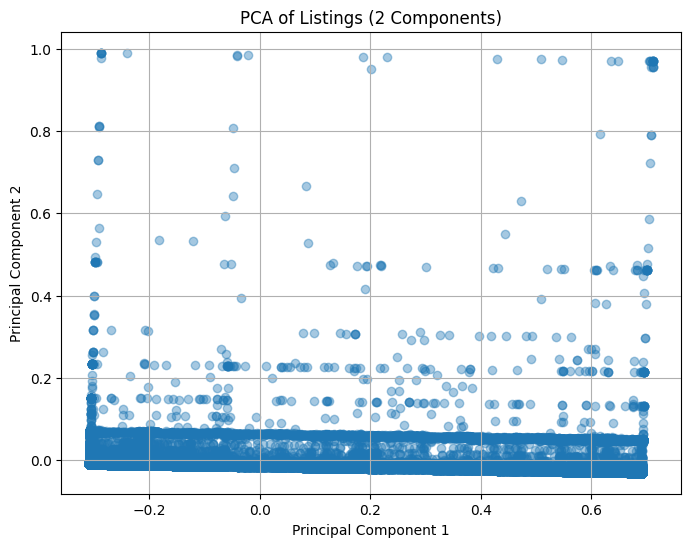

array([0.98550181, 0.01449819])

In [ ]:
# perform PCA on normalized features: minimum_nights, availability_365
X_pca_input = df_normalized[['minimum_nights', 'availability_365']]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca_input)

# explained variance
explained_variance = pca.explained_variance_ratio_

# scatter plot of PCA results
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.4)
plt.title('PCA of Listings (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

explained_variance

The first two principal components (PCs) together explain 98.56% of the variance in the data. PC1 captures the majority of this variance (98.55%), primarily driven by significant scale differences among variables such as price, availability (365 days), and minimum nights. PC2, on the other hand, captures secondary patterns, highlighting slight variations that are orthogonal to the primary spread of the data.